<a href="https://colab.research.google.com/github/gianni-sch/face_recognition/blob/master/Face_recognition_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face recognition with Tensorflow Object Detection API (LFW dataset)

In [52]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#Visuliazation
import matplotlib.pyplot as plt
#image processing
import cv2
#extracting zippped file
import tarfile
#systems
import os
print(os.listdir("/content/input"))

['.ipynb_checkpoints', 'res10_300x300_ssd_iter_140000_fp16.caffemodel', 'photos', 'lfwpeople', 'deploy.prototxt']


This is the complete code for part 1 of [my Medium article](https://medium.com/@saidakbarp/real-time-face-recognition-tflite-3fb818ac039a). The complete notebook for the part 2 of my Medium article is [here](https://www.kaggle.com/saidakbarp/face-recognition-part-2/notebook).

Face recognition relies on the dataset that has been annotated with boxes. Manually annotating faces in each images can be time consuming and for large scale training, manual annotation is impractical. For this reason we will use available face annotation tools to annotate each image with boxes. Afterwards, we can move to Object detection training part.

In [0]:
#example
imgg="/content/input/photos/francesca.jpg"
celeb=cv2.imread(imgg)

In [0]:
def show_image(image):
    plt.figure(figsize=(8,5))
    #Before showing image, bgr color order transformed to rgb order
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.show()
    

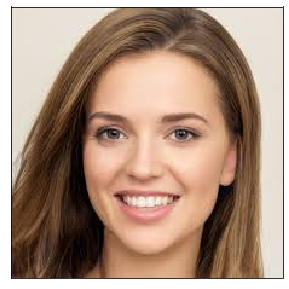

In [55]:
show_image(celeb)

In [0]:
# Our face detection function that uses haarcascade from OpenCV
def face_detection(img):
    face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_alt.xml')
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    print('Number of faces detected:', len(faces))
        
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        #img = img[y:y+h, x:x+w] # for cropping
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv_rgb

Number of faces detected: 1


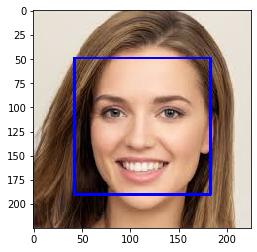

In [57]:
#imgg2=cv2.imread("/content/input/photos/ben.jpg")
a=face_detection(celeb)
plt.imshow(a)
plt.show() 

# as shown below, the library is not detecting this particular face angle of Ben Afflek

Number of faces detected: 12


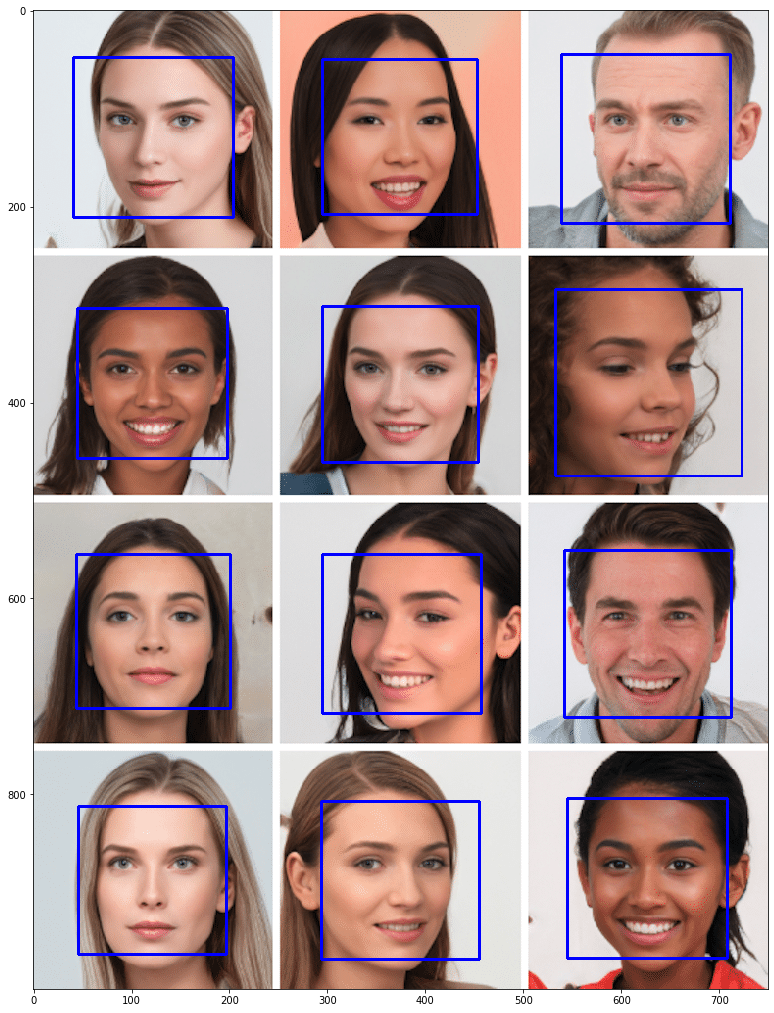

In [86]:
plt.figure(figsize=(15,18))
img=cv2.imread("/content/input/photos/peoples.jpg")
c=face_detection(img)
plt.imshow(c)
plt.show()

Haarcascade has a con: it can not detect non-frontal face images and also boxes sometimes do not include full face, clipping chins or forehead. Let us try a better model: openCV DNN

In [0]:
# using openCV DNN
# load the model
#modelFile = "../input/opencv-dnn/opencv_face_detector_uint8.pb" 
#configFile = "../input/opencv-dnn/opencv_face_detector.pbtxt"
#net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

modelFile ="/content/input/res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "/content/input/deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

In [0]:
#function to extract box dimensions
def face_dnn(img, coord=False):
    blob = cv2.dnn.blobFromImage(img, 1, (224,224), [104, 117, 123], False, False) #
    # params: source, scale=1, size=300,300, mean RGB values (r,g,b), rgb swapping=false, crop = false
    conf_threshold=0.8 # confidence at least 60%
    frameWidth=img.shape[1] # get image width
    frameHeight=img.shape[0] # get image height
    max_confidence=0
    net.setInput(blob)
    detections = net.forward()
    detection_index=0
    bboxes = []
    
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            
            if max_confidence < confidence: # only show maximum confidence face
                max_confidence = confidence
                detection_index = i
    i=detection_index        
    x1 = int(detections[0, 0, i, 3] * frameWidth)
    y1 = int(detections[0, 0, i, 4] * frameHeight)
    x2 = int(detections[0, 0, i, 5] * frameWidth)
    y2 = int(detections[0, 0, i, 6] * frameHeight)
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,0),2)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if coord==True:
        return x1, y1, x2, y2
    return cv_rgb

In [0]:
#gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
# multiple faces needs increasing the size of image as well as multiple detections
def nfaces_dnn(img):
    blob = cv2.dnn.blobFromImage(img, 1.2, (1200,1200), [104, 117, 123], False, False) #
    # params: source, scale=1, size=300,300, mean RGB values (r,g,b), rgb swapping=false, crop = false
    conf_threshold=0.6 # confidence at least 60%
    frameWidth=img.shape[1] # get image width
    frameHeight=img.shape[0] # get image height
    net.setInput(blob)
    detections = net.forward()
  
    bboxes = []
    
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
                  
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,0),2)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv_rgb

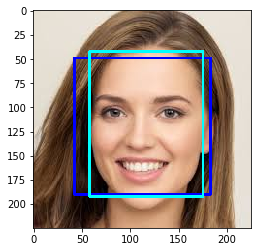

In [62]:
a=face_dnn(celeb)
plt.imshow(a)
plt.show() 

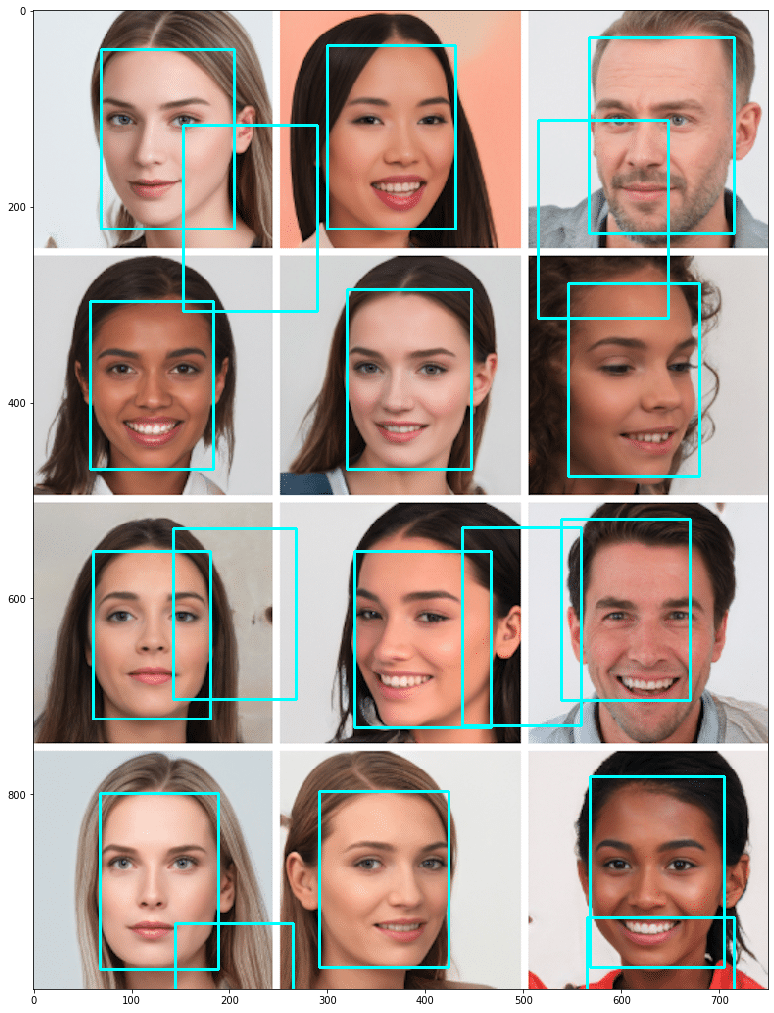

In [85]:
img=cv2.imread("/content/input/photos/peoples.jpg")
c=nfaces_dnn(img)
plt.figure(figsize=(15,18))
plt.imshow(c)
plt.show()

As output shows, although 'multiple faces' function does not register some faces from a group of people, DNN is able to detect non-frontal faces without clipping chin.

Our main purpose is to use LFW people images that have at least 20 examples ( later, obtain 100 images of top 100 celebrities from Google image search), then crop their faces (single face photos). Afterwards, we train our mobilenetV2 coco model to recognize those celebrities. Final goal is to identify celebrities from their photos.

## Now we extract LFW for face detection

Each picture is centered on a single face. The typical task is called Face Verification: given a pair of two pictures, a binary classifier must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is: given the picture of the face of an unknown person, identify the name of the person by referring to a gallery of previously seen pictures of identified persons.

Both Face Verification and Face Recognition are tasks that are typically performed on the output of a model trained to perform Face Detection. The most popular model for Face Detection is called Viola-Jones and is implemented in the OpenCV library. The LFW faces were extracted by this face detector from various online websites.

In [0]:
os.listdir('/content/input/lfwpeople/')
fname='/content/input/lfwpeople/lfwfunneled.tgz'

In [0]:
def jpg_files(members): #only extract jpg files
    for tarinfo in members:
        if os.path.splitext(tarinfo.name)[1] == ".jpg":
            yield tarinfo
def untar(fname,path="LFW"): #untarring the archive
    tar = tarfile.open(fname)
    tar.extractall(path,members=jpg_files(tar))
    tar.close()
    if path is "":
        print("File Extracted in Current Directory")
    else:
        print("File Extracted in to",  path)

In [160]:
untar(fname,"/content/working/")

File Extracted in to /content/working/


In [163]:
len(os.listdir('/content/working/LFW/lfw_funneled/')) # total number of folders (people)

5760

In [164]:
# total number of images
total = sum([len(files) for r, d, files in os.walk('/content/working/LFW/lfw_funneled/')])
print(total)

13244


In [181]:
count=0 
imglist=[]
# 
for r, d, files in os.walk('/content/working/LFW/lfw_funneled/'):   
    if len(files)>=20: 
        imglist.append(r)
        #print(count, r)
        count+=1 # counts how many folders have with at least 20 images
print(count)

62


In [166]:
#os.listdir(imglist[0])
# pick one random photo
a=np.random.randint(0,20)
b=np.random.randint(0,62)
imglist[b]

'/content/working/LFW/lfw_funneled/Lindsay_Davenport'

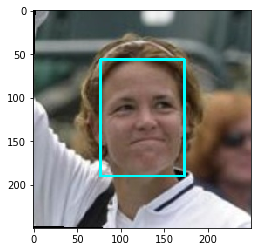

In [167]:
# show the random photo with face detected
img=imglist[b]+'/'+os.listdir(imglist[b])[a]
img=cv2.imread(img)
c=face_dnn(img)
plt.imshow(c)
plt.show()

We have a list of people (62) with at least 20 images. Now, we will use this annotation of faces, and train MobileNet NN model to recognize those people.

## Creating training and test sets

In [184]:
#remove unused folders
import shutil
pathd='/content/working/LFW/lfw_funneled/'
#shutil.rmtree(os.path.realpath('LFW'))
for dirs in os.listdir(pathd):
    if not (pathd+dirs) in imglist:
        shutil.rmtree(os.path.realpath(pathd+dirs))

NotADirectoryError: ignored

In [0]:
dirs=os.listdir(pathd)
dirs.sort()

Aby_Har-Even
76 62 181 191


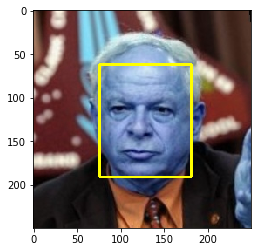

In [186]:
#example of box coordinates
#a=np.random.randint(0,20)
b=np.random.randint(0,62)
for img in os.listdir(pathd+dirs[b])[:5]:
    #print(pathd+dirs[0]+'/'+img)
    print(dirs[b])
    img=cv2.imread(pathd+dirs[b]+'/'+img)
    x1, y1, x2, y2=face_dnn(img, True)
    #print coordinates of the detected face
    print(x1, y1, x2, y2)
    plt.imshow(img)
    plt.show()

In [187]:
os.listdir('/content/working/LFW/')
pathd
#(os.listdir(pathd))

'/content/working/LFW/lfw_funneled/'

In [179]:
# # creating test and train set
from numpy import random
datadir='/content/working/LFW/'
train=datadir+'train/'
test=datadir+'test/'

if not os.path.exists(train):
    os.mkdir(train)
if not os.path.exists(test):
    os.mkdir(test)
    
for dirs in os.listdir(pathd):
    filenames = os.listdir(pathd+dirs)
    filenames.sort()  # make sure that the filenames have a fixed order before shuffling
    random.seed(402)
    random.shuffle(filenames) # shuffles the ordering of filenames (deterministic given the chosen seed)
    split = int(0.85 * len(filenames))
    train_filenames = filenames[:split] # splitting filenames into two parts
    test_filenames = filenames[split:]
    for img in train_filenames:
        full_file_name = os.path.join(pathd+dirs, img)
        cur_dir=os.path.join(train+dirs)
        #print(cur_dir)
        if not os.path.exists(cur_dir): # create this current person's folder for training
            os.mkdir(cur_dir)
        shutil.copy(full_file_name, cur_dir)
    for img in test_filenames:
        full_file_name = os.path.join(pathd+dirs, img)
        cur_dir=os.path.join(test+dirs)
        if not os.path.exists(cur_dir): # create this current person's folder for testing
            os.mkdir(cur_dir)
        shutil.copy(full_file_name, cur_dir)
        #a=full_file_name+' '+test+dirs
shutil.rmtree('/content/working/LFW/lfw_funneled/')

NotADirectoryError: ignored

In [0]:
# total number of images left
total = sum([len(files) for r, d, files in os.walk(datadir)])
print(total)

3023


In [0]:
labeldir="Labels/" # labels dir
wdir="../working/LFW/"
lab=wdir+labeldir
if not os.path.exists(lab):
    os.mkdir(lab)

In [0]:
# function for creating box labels as txt file
def label_txt(pathdr, lab_dir):
    for fol in os.listdir(pathdr):
        tfile = open(lab_dir+fol+".txt","w+")
        for img in os.listdir(pathdr+fol):
            pathimg=os.path.join(pathdr+fol, img)
            #print(pathimg)
            pic=cv2.imread(pathimg)
            x1, y1, x2, y2=face_dnn(pic, True) # face detection and then saving into txt file       
            tfile.write(img+' '+str(x1)+' '+str(x2)+' '+str(y1)+' '+str(y2)+'\n')          
        tfile.close()
    print('Saved')

In [0]:
lab_dir=lab+'train/'
os.mkdir(lab_dir)
label_txt(train, lab_dir)

lab_dir=lab+'test/'
os.mkdir(lab_dir)
label_txt(test, lab_dir)

Saved
Saved


In [0]:
#let's check if txt files are correct:
f2 = open("../working/LFW/Labels/test/Arnold_Schwarzenegger.txt","r")
print(f2.read())
f2.close()

Arnold_Schwarzenegger_0031.jpg 81 171 59 184
Arnold_Schwarzenegger_0016.jpg 76 174 58 193
Arnold_Schwarzenegger_0036.jpg 74 175 63 201
Arnold_Schwarzenegger_0006.jpg 81 171 61 189
Arnold_Schwarzenegger_0011.jpg 77 167 65 192
Arnold_Schwarzenegger_0041.jpg 77 176 62 194
Arnold_Schwarzenegger_0007.jpg 75 173 60 197



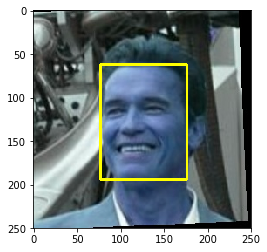

In [0]:
# checking Arnold_Schwarzenegger_0041.jpg
pic=cv2.imread(test+'Arnold_Schwarzenegger/Arnold_Schwarzenegger_0041.jpg')
cv2.rectangle(pic,(77 ,62),(176,194),(255,255,0),2)
plt.imshow(pic)
plt.show()

As we can see box annotation is correct! Now, we have to save annotations as tfrecord:

# Creating tfrecords with annotated images

In [0]:
def read_txt(person, photo):  
    txtfile = labels+person+".txt"
    txtfile_contents = open(txtfile, "r")
    txtlines = txtfile_contents.readlines()
    txtfile_contents.close()
    for line in txtlines:
        if photo in line:
            txtlines=line
    return txtlines

In [0]:
!pip install object_detection >obj_dtc.txt # installing object detection

You are using pip version 18.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
from PIL import Image
from object_detection.utils import dataset_util

# flags = tf.app.flags
# flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
# FLAGS = flags.FLAGS
# modified from source: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md
def create_tf_example(photo, person, iclass, foldr):
    # one image at a time
    img_f=os.path.join(foldr+person,photo+".jpg")
    pic = Image.open(img_f)
    height = pic.height # Image height
    width = pic.width # Image width
    filename = str.encode(photo) # Filename of the image. Empty if image is not from file
    #encoded_image_data = None # Encoded image bytes
    image_data = tf.gfile.GFile(img_f,'rb').read()
    
    image_format = b'jpeg' #None #  or b'png'
    #declare coordinates
    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)
    
    txtlines = read_txt(person, photo)

    labels = txtlines.split()

    xmins.append(float(labels[1])/width)
    xmaxs.append(float(labels[2])/width)
    ymins.append(float(labels[3])/height)
    ymaxs.append(float(labels[4])/height)

    classes_text.append(str.encode(person))
    classes.append(iclass) #### iterator is needed
    #print(xmins, xmaxs, ymins, ymaxs, classes_text, photo, img_f) # for test purposes
    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(image_data),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example



In [0]:
import tensorflow as tf
#saving tfrecords
def save_tf(folder):
    tf_file=folder.split('/')[-2] +'.tfrecord'
    writer = tf.python_io.TFRecordWriter('../working/'+tf_file)
    
    labelmap = '../working/'+'object_label.pbtxt' # for model training
    txtf = open(labelmap, "w")
    
    labels = '../working/'+'labels.txt' # for android deployment
    txtl = open(labels, "w")
    
    for ind, person in enumerate(os.listdir(folder)):
        iclass=ind+1
        txtf.write("item\n{\n  id: %s\n  name: '%s'\n}\n"%(iclass,person))
        txtl.write("%s\n"%person)
        #print(iclass, person)
        for photo in os.listdir(folder+person):
            tf_example = create_tf_example(photo.split('.')[0], person, iclass, folder) #004.jpg, arnold, 1
            #print('Folder:', pathd+fol, iclass)
            writer.write(tf_example.SerializeToString())
    txtf.close()
    writer.close()

In [0]:
labels='../working/LFW/Labels/train/'
save_tf(train)

labels='../working/LFW/Labels/test/'
save_tf(test)

In [0]:
os.stat('../working/train.tfrecord').st_size/1024/1024

46.40524768829346

In [0]:
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
make_tarfile('test_images.tar.gz','/kaggle/working/LFW/test')        
shutil.rmtree('/kaggle/working/LFW/')
#os.listdir('/kaggle/working/LFW/test')

In [0]:
os.listdir('/kaggle/working/')

['.ipynb_checkpoints',
 'test.tfrecord',
 'test_images.tar.gz',
 'labels.txt',
 '__notebook_source__.ipynb',
 'object_label.pbtxt',
 'train.tfrecord',
 'obj_dtc.txt']

In [0]:
# for test purposes
#pic = Image.open('../working/LFW/test/Jennifer_Capriati/Jennifer_Capriati_0007.jpg')
#height = pic.height # Image height
#width = pic.width # Image width
#pic=cv2.imread('../working/LFW/test/Jennifer_Capriati/Jennifer_Capriati_0007.jpg')
#cv2.rectangle(pic,(int(0.304*width),int(0.236*height)),(int(0.692*width),int(0.768*height)),(255,255,0),2)
#plt.imshow(pic)
#plt.show()

# Transfer learning for Object detection models

In the first part of our notebook, we created annotated images of people from LFW dataset. In this notebook, we will train an existing model to recognize those 62 people using Tensorflow object detection library.  
P.S. refer to version 17 for the quantized model; this is a float type model.

In [103]:
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print(os.listdir("./input//"))
# Any results you write to the current directory are saved as output.


['.ipynb_checkpoints', 'res10_300x300_ssd_iter_140000_fp16.caffemodel', 'photos', 'opencvdnnfp', 'lfwpeople', 'deploy.prototxt']


In [110]:
import tensorflow as tf
%cd /content/working/ 
# changing the directory for installation of below modules
# tensorflow models section has an object detection library
# piping logs to text files, otherwise the notebook is not very readable
!git clone --quiet https://github.com/tensorflow/models.git > models.txt
# protobuf is needed for creating py files from models library above
!apt-get install -qq protobuf-compiler > proto.txt 
# pycoco for coco scores
!pip install -q pycocotools > pycoco.txt
# creating py files from protos
%cd ..
%cd /content/working/models/research
!protoc object_detection/protos/*.proto --python_out=.
# setting path, if not set, python can not use object detection library (from models)
import os
os.environ['PYTHONPATH'] += ':/content/working/models/research/:/content/working/models/research/slim/'
# if prints OK, then installation and environment are set up correctly 
!python object_detection/builders/model_builder_test.py

/content/working
fatal: destination path 'models' already exists and is not an empty directory.
/content
/content/working/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_fast

In [0]:
# copy coco config to the working dir for editing
!cp /content/my-training/ssd_mobilenet_v2_coco.config /content/working/

In [0]:
# modified from https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/
# changing config file by changing the path to records and setting variables
import re
pipeline_fname="/content/working/ssd_mobilenet_v2_coco.config"
fine_tune_checkpoint="/content/my-training/model.ckpt"
train_record_fname="/content/working/train.tfrecord"
test_record_fname="/content/working/test.tfrecord"
label_map_pbtxt_fname="/content/working/object_label.pbtxt"
batch_size=64
num_steps=20000 # more steps of training gives higher accuracy
num_classes=62 # specify classes
num_examples=5000 # generate examples by augmenting existing images in tfrecords

with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files both train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(test.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)
    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)
    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)
    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    s = re.sub('num_examples: [0-9]+',
               'num_examples: {}'.format(num_examples), s) 
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [0]:
# folder for saving trained model
!rm -r /kaggle/working/training
os.mkdir('/content/working/training')

In [0]:
#!ls /kaggle/working/
train='/content/working/training/'

In [0]:
# if you are training for the first time, you can remove this cell!!!
# this is for further training from my last checkpoint
!cp /kaggle/input/float-trained16k/* /kaggle/working/training/
#opening checkpoint text file to edit the last step:
ch=open('/content/working/training/checkpoint','w')
ch.write('model_checkpoint_path: "model.ckpt-16000"\nall_model_checkpoint_paths: "model.ckpt-16000"')
ch.close() # without checkpoint step, training does not continue

cp: cannot stat '/kaggle/input/float-trained16k/*': No such file or directory


In [0]:
#training starts by running model_main.py and passing the paths
!python /kaggle/working/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir=/kaggle/working/training/ \
    --alsologtostderr > /kaggle/working/train.txt
print("Finished training")

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [0]:
!ls /content/working/training
#!cat {pipeline_fname}

checkpoint


In [0]:
!cp {pipeline_fname} /kaggle/working/training/
conf_path='/content/working/training/ssd_mobilenet_v2_coco.config'

In [0]:
#save frozen graph of the model for inference later (for notebook usage only, not for tflite converting)
import re
import numpy as np

output_directory = '/content/working/trained_model'

lst = os.listdir(train)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')
last_model_path = os.path.join(train, last_model)

print(last_model_path)
!python /kaggle/working/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path} \
    > /kaggle/working/graph.txt
print('Finished exporting')

ValueError: attempt to get argmax of an empty sequence

In [0]:
!ls /content/working/trained_model/

In [0]:
os.mkdir('/content/working/freezetflite')
outd='/content/working/freezetflite'

In [0]:
# freezing graph for tensorflow lite for android use
!python /content/working/models/research/object_detection/export_tflite_ssd_graph.py \
--pipeline_config_path={conf_path} \
--trained_checkpoint_prefix={last_model_path} \
--output_directory={outd} \
--add_postprocessing_op=true

In [0]:
# converting frozen graph to obtain tflite, used on Android later
!tflite_convert  --graph_def_file=/content/working/freezetflite/tflite_graph.pb \
--output_file=/content/working/freezetflite/62faces_float.tflite \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--input_shape=1,300,300,3 \
--allow_custom_ops 

[[](http://)](http://)Our model has been trained. Now we will run inference on some images to check whether it is detecting and recognizing faces.

In [0]:
# modified from https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/
%cd /content/working/models/research/object_detection
import warnings
warnings.filterwarnings('ignore')

PATH_TO_CKPT='/content/working/trained_model/frozen_inference_graph.pb'
PATH_TO_LABELS = label_map_pbtxt_fname
PATH_DIR ='/content/input/faces-data/'
TEST_IMAGE_PATHS =[os.path.join(PATH_DIR+i) for i in os.listdir(PATH_DIR)]

#import matplotlib; matplotlib.use('Agg')
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
#from matplotlib import pyplot as plt

from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
#%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=5)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

In [0]:
import shutil
shutil.rmtree('/content/working/models')

In [0]:
!ls /content/working/training/

In [0]:
!ls /content/working/

In [0]:
!ls /content/working/trained_model/